In [1]:
# UNCOMMENT first with internet option turned on
# Use GPU env

# !pip download tabpfn --no-deps -d pip-packages

# from tabpfn import TabPFNClassifier
# TabPFNClassifier(N_ensemble_configurations = 64, device = 'cuda:0')

# !mv /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt pip-packages/
# !zip -r pip-packages.zip pip-packages

# now you need to download the zip and upload it as dataset with the plus in the top left
# then you need to add it to the notebook as data on the right, and name it `pip-packages-icr`

# now you can turn internet off and still install, like below

In [2]:
# !pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages

In [3]:
# !mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
# !cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyprojroot import here

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

### Data Pull

In [5]:
# load data
local_dir = str(here()) + '/'
kaggle_dir = '/kaggle/input/'
train_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/greeks.csv')

# join greeks and add Epsilon
train_df = pd.merge(train_df, greeks_df, on = 'Id')
train_df = train_df.drop(['Beta', 'Gamma', 'Delta'], axis = 1)
train_df['Epsilon'] = train_df['Epsilon'].replace('Unknown', np.nan)

# dropping rows with missing values in Epsilon as it helps with class imbalance
# if future data does have this column, it will be important to know if it is missing
train_df = train_df[train_df['Epsilon'].isna() == False].copy()
train_df['Epsilon'] = pd.to_datetime(train_df['Epsilon'])

# change epsilon to months since 1-1-2019 when data started to pick up
train_df['Months Since 1-1-2019'] = (train_df['Epsilon'] - pd.to_datetime('2019-01-01')).dt.days // 30
train_df = train_df.drop('Epsilon', axis = 1)
train_df.reset_index(drop = True, inplace = True)

In [6]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

# Preprocess Data

In [7]:
# set random seed
random_seed = 101010
np.random.seed(random_seed)

# pre-process data
y_alpha = train_df['Alpha']
y_class = train_df['Class']
x = train_df.drop(['Id', 'Alpha', 'Class'], axis = 1, inplace = False)

# create x and y train
X_train = x.copy()
y_train_alpha = y_alpha.copy()
alpha_encoder = LabelEncoder()
y_train_alpha = alpha_encoder.fit_transform(y_train_alpha)
y_train_class = y_class.copy()

# scale and impute data
X_train['EJ'].replace({'A': 0, 'B': 1}, inplace = True)
X_train_columns = X_train.columns
X_train_index = X_train.index
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
knn_imputer = KNNImputer()
X_train = knn_imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = X_train_columns, index = X_train_index)

# Engineer Features

### Model Prediction Features
KNN, Logistic Regression, SVM, Gradient Boosting, and TabPFN

In [8]:
def fit_model(model_name, model, X_train, y_train, X_test, features):
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    model.fit(X, y)
    model_predictions = model.predict_proba(test)
    predictions_df = pd.DataFrame(model_predictions, columns = model.classes_, index=X_test.index)
    predictions_df.columns = [model_name + '_' + str(col) for col in predictions_df.columns]
    
    return predictions_df

In [9]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_alpha)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_alpha[train_index], y_train_alpha[test_index]
    
    model_features = [
        'DU', 'CR', 'AB', 'DA', 'DH', 'BC', 'FR', 'EP', 'DI', 'FL', 'EU', 'EH', 'Months Since 1-1-2019'
    ]
    
    # KNN
    knn_features = model_features[0:3]
    knn_features.append(model_features[-1])
    knn = KNeighborsClassifier(n_neighbors = 7)
    knn_predictions = fit_model('KNN 7', knn, fold, fold_y, oof, knn_features)
    
    # Extra Trees
    extra_trees = ExtraTreesClassifier(n_estimators = 250, random_state = random_seed)
    extra_trees_predictions = fit_model('Extra Trees', extra_trees, fold, fold_y, oof, model_features)
    
    # TabPFN
    tabpfn = TabPFNClassifier(N_ensemble_configurations = 64, seed = random_seed)
    tabpfn_predictions = fit_model('TabPFN', tabpfn, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([knn_predictions, extra_trees_predictions, tabpfn_predictions], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [10]:
pre_fit_models = {
    'KNN 7': knn.fit(X_train[knn_features], y_train_alpha),
    'Extra Trees': extra_trees.fit(X_train[model_features], y_train_alpha),
    'TabPFN': tabpfn.fit(X_train[model_features], y_train_alpha)
}

X_train = pd.concat([X_train, model_prediction_features_df], axis = 1)

In [11]:
for pred_class in y_train_alpha:
    X_train['Alpha_' + str(pred_class)] = X_train['Extra Trees_' + str(pred_class)] + X_train['TabPFN_' + str(pred_class)]

In [12]:
print('Shape of X:', X_train.shape)
print('Shape of y:', y_train_alpha.shape)

Shape of X: (473, 73)
Shape of y: (473,)


In [13]:
# print('Shape of X:', X_test.shape)
# print('Shape of y:', y_test.shape)

# Modeling

In [17]:
def competition_log_loss(y_true, y_pred):
    # calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
    proba_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    proba_0 = 1 - proba_1
    
    # count each class
    class_0 = np.sum(1 - y_true)
    class_1 = np.sum(y_true)

    # log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
    log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1
    
    # return average log loss
    return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

### XGBoost

In [18]:
xgb = XGBClassifier(random_state = random_seed)

parameters = {
    'booster': ['gbtree'],
    'learning_rate': [0.02],
    'n_estimators': [300],
    'max_depth': [6],
    'gamma': [0.3],
    'min_child_weight': [2],
    'max_delta_step': [1],
    'subsample': [0.7],
    'base_score': [0.85],
    'n_jobs': [-1],
}

grid_obj = GridSearchCV(xgb, parameters, scoring = balanced_log_loss_scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train_class)
xgb = grid_obj.best_estimator_
xgb.fit(X_train, y_train_class)

XGBClassifier(base_score=0.85, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=101010, reg_alpha=0, reg_lambda=1, ...)

In [19]:
# view results of grid search
xgb_results = pd.DataFrame(grid_obj.cv_results_)
xgb_results.sort_values('rank_test_score')
# print results of roc auc score
print('Balanced Log Loss:', np.round(xgb_results['mean_test_score'].max() * -1, 4))

Balanced Log Loss: 0.2172


In [36]:
value = 83

print(1 - X_train['KNN 7_0'][value])
print(1 - X_train['Extra Trees_0'][value])
print(1 - X_train['TabPFN_0'][value])
print(y_train_pred[value])

0.2857142857142857
0.36
0.33311301469802856
0.20661779


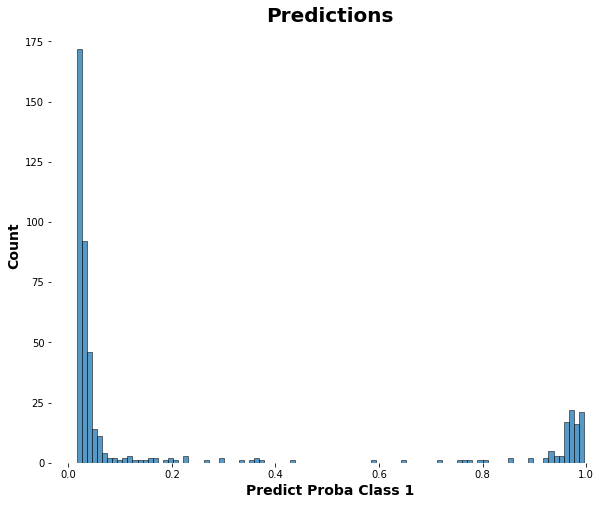

In [20]:
# histogram of y_train_pred
y_train_pred = xgb.predict_proba(X_train)[:,1]

plt.figure(figsize = (10, 8))
plt.title('Predictions', fontdict = font_dict_header)
sns.histplot(y_train_pred, bins = 100, kde = False)
plt.box(False)
plt.xlabel('Predict Proba Class 1', fontdict = font_dict_axistitle)
plt.ylabel('Count', fontdict = font_dict_axistitle)
plt.box(False)
plt.show()

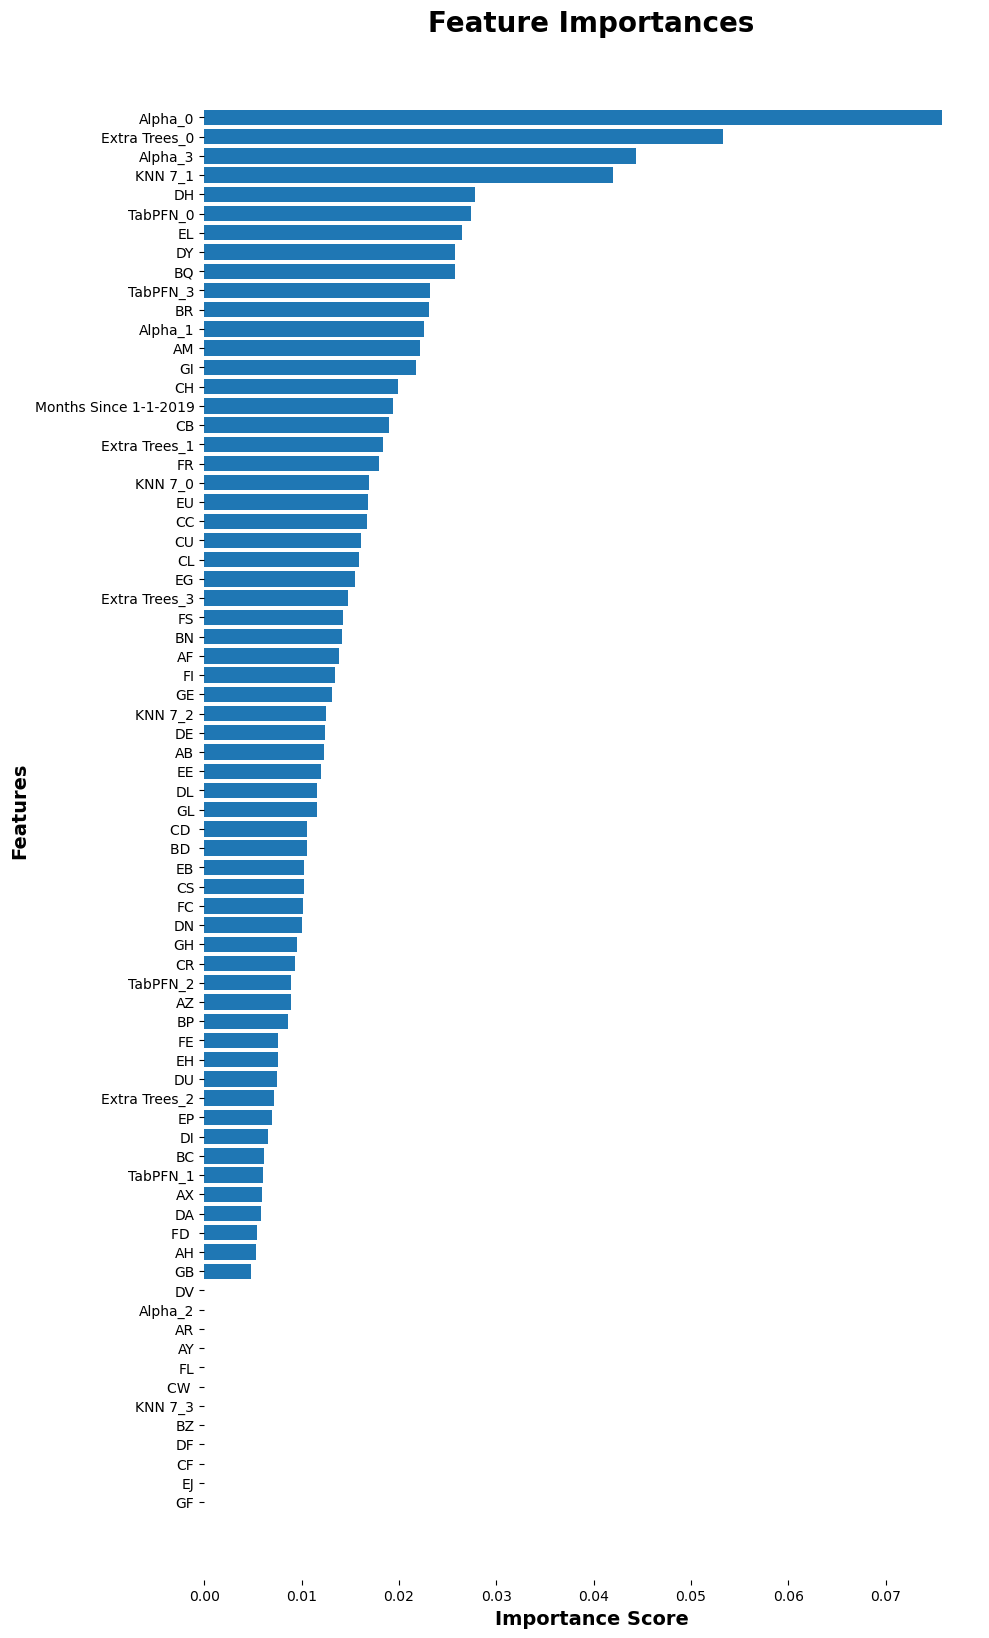

In [18]:
# plot feature importances
importances = pd.Series(xgb.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

### Test Sampling Strategies

In [19]:
def model_cross_validation(X, y, models, model_names, n_splits = 5):
    skf = StratifiedKFold(n_splits = n_splits, random_state = random_seed, shuffle = True)
    
    # create dataframe to hold results
    results_df = pd.DataFrame(columns = ['Model', 'Fold', 'Accuracy', 'ROC AUC', 'Log Loss'])
    
    for sampling_strategy in ['SMOTE']:
        print('----------------------------------')
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            if sampling_strategy == 'SMOTE':
                X_train, y_train = SMOTE(random_state = random_seed).fit_resample(X_train, y_train)
            elif sampling_strategy == 'RandomOverSampler':
                X_train, y_train = RandomOverSampler(random_state = random_seed).fit_resample(X_train, y_train)
            else:
                pass
            
            model_predictions = {}
            for model, model_name in zip(models, model_names):
                if sampling_strategy == 'None':
                    model_name = model_name
                else:
                    model_name = model_name + ' with ' + sampling_strategy
                
                print(model_name, 'Fold', i + 1)
                if str.startswith(model_name, 'TabPFN'):
                    model.fit(X_train[X_train_columns[:-16]], y_train)
                    y_pred = model.predict(X_test[X_train_columns[:-16]])
                    
                    y_proba = model.predict_proba(X_test[X_train_columns[:-16]])
                    y_proba_class_0 = y_proba[:,0].sum()
                    y_proba_class_1 = y_proba[:,1].sum()
                    new_probabilities = y_proba * np.array([[1/(y_proba_class_0 if i==0 else y_proba_class_1) for i in range(y_proba.shape[1])]])
                    y_proba = new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
                    
                    y_proba = y_proba[:, 1]
                else:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    
                    y_proba = model.predict_proba(X_test)
                    y_proba_class_0 = y_proba[:,0].sum()
                    y_proba_class_1 = y_proba[:,1].sum()
                    new_probabilities = y_proba * np.array([[1/(y_proba_class_0 if i==0 else y_proba_class_1) for i in range(y_proba.shape[1])]])
                    y_proba = new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
                    
                    y_proba = y_proba[:, 1]
                
                fold_accuracy = accuracy_score(y_test, y_pred)
                fold_roc_auc = roc_auc_score(y_test, y_proba)
                fold_log_loss = competition_log_loss(y_test, y_proba)
                
                new_result_index = len(results_df)
                new_results_row = pd.DataFrame({
                    'Model': model_name, 
                    'Fold': i + 1, 
                    'Accuracy': fold_accuracy, 
                    'ROC AUC': fold_roc_auc,
                    'Log Loss': fold_log_loss
                }, index = [new_result_index])
                
                results_df = pd.concat([results_df, new_results_row])
                model_predictions[str(model_name) + '_proba'] = y_proba.tolist()
                
            # average predictions
            if sampling_strategy == 'None':
                model_name = 'Average'
            else:
                model_name = 'Average' + ' with ' + sampling_strategy
            
            
            weighted_proba = []
            for prediction in model_predictions:
                if str.startswith(prediction, 'XGBoost'):
                    weighted_proba.append(np.array(model_predictions[prediction]) * 0.4)
                elif str.startswith(prediction, 'Extra Trees'):
                    weighted_proba.append(np.array(model_predictions[prediction]) * 0.2)
                elif str.startswith(prediction, 'SVM'):
                    weighted_proba.append(np.array(model_predictions[prediction]) * 0.4)
                else:
                    weighted_proba.append(np.array(model_predictions[prediction]) * 0)
            
            y_proba = np.sum(weighted_proba, axis = 0)
            y_pred = np.where(y_proba > 0.5, 1, 0)
            fold_accuracy = accuracy_score(y_test, y_pred)
            fold_roc_auc = roc_auc_score(y_test, y_proba)
            fold_log_loss = competition_log_loss(y_test, y_proba)
            
            new_result_index = len(results_df)
            new_results_row = pd.DataFrame({
                'Model': model_name, 
                'Fold': i + 1, 
                'Accuracy': fold_accuracy, 
                'ROC AUC': fold_roc_auc,
                'Log Loss': fold_log_loss
            }, index = [new_result_index])
            
            results_df = pd.concat([results_df, new_results_row])
        
    return results_df

In [20]:
xtree = ExtraTreesClassifier(n_estimators = 250, random_state = random_seed)
svm = SVC(probability = True, random_state = random_seed)
models = [xgb, xtree, svm]
model_names = ['XGBoost', 'Extra Trees', 'SVM']

In [21]:
cv_results = model_cross_validation(X_train, y_train_class, models, model_names)

----------------------------------
XGBoost with SMOTE Fold 1
Extra Trees with SMOTE Fold 1
SVM with SMOTE Fold 1
XGBoost with SMOTE Fold 2
Extra Trees with SMOTE Fold 2
SVM with SMOTE Fold 2
XGBoost with SMOTE Fold 3
Extra Trees with SMOTE Fold 3
SVM with SMOTE Fold 3
XGBoost with SMOTE Fold 4
Extra Trees with SMOTE Fold 4
SVM with SMOTE Fold 4
XGBoost with SMOTE Fold 5
Extra Trees with SMOTE Fold 5
SVM with SMOTE Fold 5


In [22]:
# find best sampling strategy for submission
results = cv_results.drop('Fold', axis = 1).groupby('Model').mean()
results['Accuracy Z Score'] = (results['Accuracy'] - results['Accuracy'].mean()) / results['Accuracy'].std()
results['ROC AUC Z Score'] = (results['ROC AUC'] - results['ROC AUC'].mean()) / results['ROC AUC'].std()
results['Log Loss Z Score'] = ((results['Log Loss'] - results['Log Loss'].mean()) / results['Log Loss'].std()) * -1
results['Average Z Score'] = results[['ROC AUC Z Score','Log Loss Z Score']].mean(axis = 1)
results.sort_values('Log Loss Z Score', ascending = False)

,Accuracy,ROC AUC,Log Loss,Accuracy Z Score,ROC AUC Z Score,Log Loss Z Score,Average Z Score
Model,,,,,,,
Average with SMOTE,0.936529,0.974880,0.191050,-0.409824,0.832742,0.723714,0.778228
XGBoost with SMOTE,0.942912,0.974002,0.206840,0.295915,0.410305,0.499330,0.454818
SVM with SMOTE,0.930168,0.970142,0.224497,-1.113086,-1.447843,0.248416,-0.599714
Extra Trees with SMOTE,0.951333,0.973575,0.345525,1.226995,0.204796,-1.471461,-0.633332


### Submission

In [23]:
def prediction_pipeline(X):
    X['EJ'].replace({'A': 0, 'B': 1}, inplace = True)
    X = X.select_dtypes(include = [np.number])
    X['Months Since 1-1-2019'] = [X_train['Months Since 1-1-2019'].max() + 1] * len(X)
    
    X_columns = X.columns
    X_index = X.index
    
    X = standard_scaler.transform(X)
    X = knn_imputer.transform(X)
    X = pd.DataFrame(X, columns = X_columns, index = X_index)

    for model in pre_fit_models:
        if model == 'KNN 7':
            model_predictions = pre_fit_models[model].predict_proba(X[knn_features])
        else:
            model_predictions = pre_fit_models[model].predict_proba(X[model_features])
            
        predictions_df = pd.DataFrame(model_predictions, columns = pre_fit_models[model].classes_, index = X_index)        
        predictions_df.columns = [model + '_' + str(col) for col in predictions_df.columns]
        X = pd.concat([X, predictions_df], axis = 1)
        
    for pred_class in y_train_alpha:
        X['Alpha_' + str(pred_class)] = X['Extra Trees_' + str(pred_class)] + X['TabPFN_' + str(pred_class)]
    
    model_train, model_y = SMOTE(random_state = random_seed).fit_resample(X_train, y_train_class)
    
    models = {'xgb': {'model': xgb, 'weight': 0.4},
              'xtree': {'model': xtree, 'weight': 0.2},
              'svm': {'model': svm, 'weight': 0.4}}

    weighted_proba = []
    
    for model_name, model_info in models.items():
        model_info['model'].fit(model_train, model_y)
        prediction = model_info['model'].predict_proba(X)
        class_0 = prediction[:,0].sum()
        class_1 = prediction[:,1].sum()
        probabilities = prediction * np.array([[1/(class_0 if i==0 else class_1) for i in range(prediction.shape[1])]])
        proba = probabilities / np.sum(probabilities, axis = 1, keepdims = 1)
        proba = proba[:, 1]
        
        weighted_proba.append(proba * model_info['weight'])

    X['class_1'] = np.sum(weighted_proba, axis = 0)
    X['class_0'] = 1 - X['class_1']
        
    return X

In [24]:
X_test = prediction_pipeline(test_df)

In [25]:
predictions = X_test[['class_0', 'class_1']]
submission = pd.concat([test_df[['Id']], predictions], axis = 1)
submission.to_csv('submission.csv', index = False)

In [26]:
submission

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5
